#### 1. Feedforward Neural Network for Regression with PyTorch
This notebook demonstrates how to build, train, and evaluate a feedforward neural network for a regression task using PyTorch. We'll also include validation, precision, recall, accuracy calculations, and plots for loss over epochs and the ROC curve.



In [26]:
# Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc
from tqdm import tqdm

#### 2. Generate Synthetic Data
We’ll create a synthetic dataset for this example.

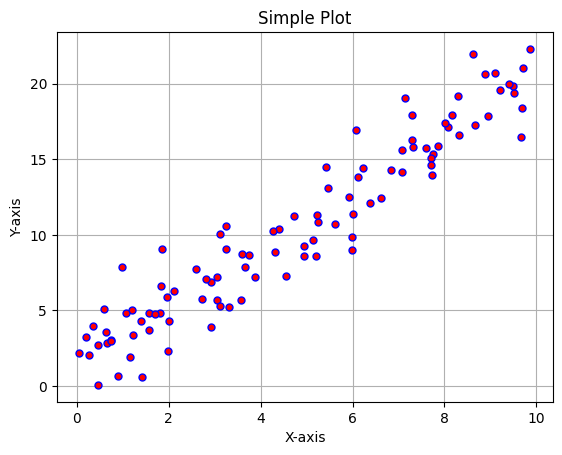

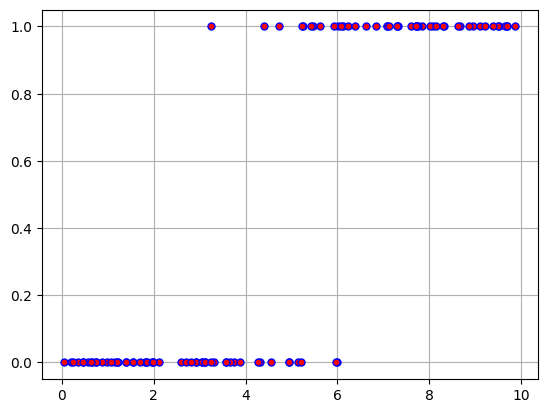

In [27]:
# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # 100 samples, 1 feature
y = 2 * X + 1 + np.random.randn(100, 1) * 2  # Linear relation with noise
plt.plot(X,y,marker='o', linestyle='None',markersize=5, markerfacecolor='red', markeredgecolor='blue')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot')
plt.grid(True)
plt.show()  # Plot will display here

# Convert to binary classification problem
y = (y > y.mean()).astype(int)
plt.plot(X,y,marker='o', linestyle='None',markersize=5, markerfacecolor='red', markeredgecolor='blue')
plt.grid(True)
plt.show()
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data
# StandardScaler: This is a class from the sklearn.preprocessing module in Python. It standardizes features by removing the mean and scaling to unit variance. This means it will transform your data such that its distribution will have a mean value 0 and a standard deviation of 1.
scaler = StandardScaler()
# fit_transform on X_train: Calculates and applies scaling based on the training data.
# transform on X_val and X_test: Applies the same scaling parameters from the training data to ensure consistency.
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### 3. Create PyTorch Dataset and DataLoader
Convert the data into PyTorch tensors and create DataLoader objects.

In [28]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

#### 4. Define the Model
Create a simple feedforward neural network.

In [29]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = FeedforwardNN(input_dim=1)

#### 5. Define Loss Function and Optimizer
We’ll use Binary Cross-Entropy (BCE) as the loss function and Adam as the optimizer.

In [30]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#### 6. Train the Model with Validation and Progress Bar
Train the model for a specified number of epochs and evaluate on the validation set.

In [31]:
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze() #The squeeze() function in PyTorch is used to remove dimensions of size 1 from a tensor. This can be particularly useful when you want to simplify the shape of your tensor, making it more compact and easier to work with.
            loss = criterion(outputs, y_batch.squeeze())  # Squeeze the target tensor
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_correct += (predicted == y_batch.squeeze()).sum().item()  # Squeeze the target tensor
            train_total += y_batch.size(0)
            pbar.update(1)
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / train_total)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_outputs = []
    val_targets = []
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_output = model(X_val_batch).squeeze()
            val_loss += criterion(val_output, y_val_batch.squeeze()).item()  # Squeeze the target tensor
            predicted = (val_output > 0.5).float()
            val_correct += (predicted == y_val_batch.squeeze()).sum().item()  # Squeeze the target tensor
            val_total += y_val_batch.size(0)
            val_outputs.extend(val_output.numpy())
            val_targets.extend(y_val_batch.squeeze().numpy())  # Squeeze the target tensor
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_correct/train_total:.4f}, Val Acc: {val_correct/val_total:.4f}')


Epoch 10/100: 100%|██████████| 4/4 [00:00<00:00, 1002.28batch/s]


Epoch [10/100], Loss: 0.9431, Val Loss: 0.1743, Train Acc: 0.9000, Val Acc: 0.9500


Epoch 20/100: 100%|██████████| 4/4 [00:00<00:00, 1003.36batch/s]


Epoch [20/100], Loss: 0.7899, Val Loss: 0.1438, Train Acc: 0.9167, Val Acc: 0.9500


Epoch 30/100: 100%|██████████| 4/4 [00:00<00:00, 1336.08batch/s]


Epoch [30/100], Loss: 0.7114, Val Loss: 0.1434, Train Acc: 0.9000, Val Acc: 0.9500


Epoch 40/100: 100%|██████████| 4/4 [00:00<00:00, 1003.30batch/s]


Epoch [40/100], Loss: 0.7565, Val Loss: 0.1398, Train Acc: 0.9000, Val Acc: 0.9500


Epoch 50/100: 100%|██████████| 4/4 [00:00<00:00, 1003.24batch/s]


Epoch [50/100], Loss: 0.7035, Val Loss: 0.1450, Train Acc: 0.9000, Val Acc: 0.9500


Epoch 60/100: 100%|██████████| 4/4 [00:00<00:00, 1002.34batch/s]


Epoch [60/100], Loss: 0.7068, Val Loss: 0.1534, Train Acc: 0.9167, Val Acc: 0.9500


Epoch 70/100: 100%|██████████| 4/4 [00:00<00:00, 1003.48batch/s]


Epoch [70/100], Loss: 0.7170, Val Loss: 0.1286, Train Acc: 0.9167, Val Acc: 0.9500


Epoch 80/100: 100%|██████████| 4/4 [00:00<00:00, 802.24batch/s]


Epoch [80/100], Loss: 0.7635, Val Loss: 0.1546, Train Acc: 0.9167, Val Acc: 0.9500


Epoch 90/100: 100%|██████████| 4/4 [00:00<00:00, 866.95batch/s]


Epoch [90/100], Loss: 0.6530, Val Loss: 0.1364, Train Acc: 0.9000, Val Acc: 0.9500


Epoch 100/100: 100%|██████████| 4/4 [00:00<00:00, 1336.19batch/s]

Epoch [100/100], Loss: 0.7135, Val Loss: 0.1211, Train Acc: 0.9000, Val Acc: 0.9500


#### 7. Calculate Precision, Recall, and Accuracy
Evaluate the model on the test set using precision, recall, and accuracy

In [32]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()
    y_true = y_test_tensor.numpy()
    y_pred_class = (y_pred > 0.5).astype(int)

# Calculate metrics
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
accuracy = accuracy_score(y_true, y_pred_class)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}')


Precision: 1.0000, Recall: 0.8750, Accuracy: 0.9500


#### 8. Plot Loss and ROC Curve
Visualize the loss over epochs and the ROC curve for the validation set

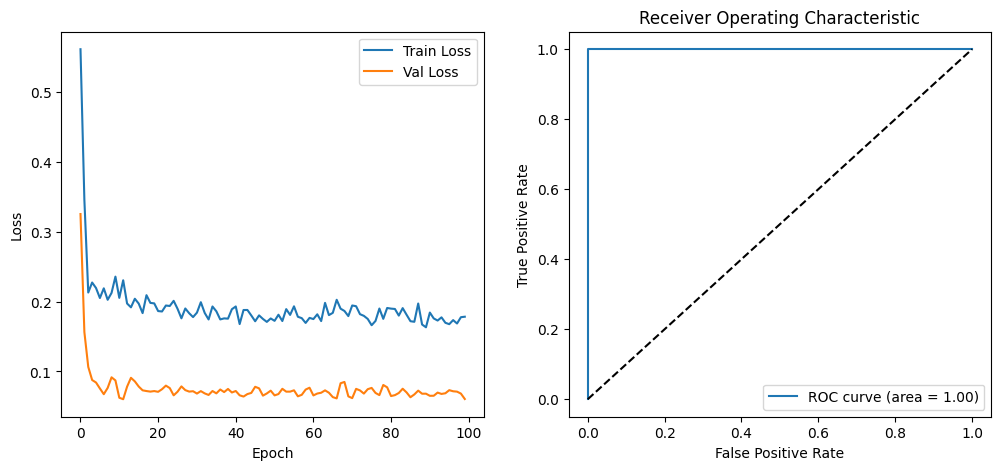

In [33]:
# Plot loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot ROC curve
fpr, tpr, _ = roc_curve(val_targets, val_outputs)
roc_auc = auc(fpr, tpr)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

plt.show()
